In [2]:
import pandas as pd   # We give the libraries short names for easier referencing
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline  
# This allows us to display plots right within our Jupyter notebook

## 1. Brief Recap of Last Session

Last week we introduced Pandas DataFrames and Series objects. Let's start off with a few exercises to review some of the concepts we talked about last week:

1). Using np.random.normal(size=(rows, columns)), construct a Pandas DataFrame with columns 'a', 'b', 'c' (use the default integer index). 

2). Before doing any experiments, what is the probability that a row in your DataFrame satisfies (a>0, b>0, c<0)? 

3). Using what you know about filtering DataFrames, test your prediction. If you repeat the experiment and make 'rows' larger when you construct the DataFrame, what do you see?

4). Write a little function that only returns positive normal random variables. In other words, your function should first generate a candidate normal random variable, discard it if it isn't positive, then try again, etc. Now, add a new column to your DataFrame, 'd', with only positive normal random variables. Find the number of rows such that a,b>d, and c<d. 

5). You now have a df with 4 columns. Construct a Pandas Series called Sers with the same index as your df; if a,b>d and c<d, the corresponding entry in Sers should be equal to d. Otherwise, it should be a^2+b^2+c^2. 

## 2. Missing Data, Dtypes, Merges:

We're going to analyze Spotify data. The data exists in three csv files. Let's pull those into our notebook now:

In [3]:
data_dir = '../datasets/kworb/'
artists = pd.read_csv(data_dir + 'artists.csv')
tracks = pd.read_csv(data_dir + 'tracks.csv')
track_daily = pd.read_csv(data_dir + 'track_daily.csv')

In [4]:
print(artists.shape)
print(tracks.shape)
print(track_daily.shape)

(10000, 4)
(47599, 66)
(416752, 61)


The data in track_daily has different columns for different countries (as well as a column specifying the track, the global plays, and the date), and different rows corresponding to track plays on different days. Take a look at the columns in our dataframe.

In [5]:
track_daily.columns

Index([u'AD', u'AR', u'AT', u'AU', u'BE', u'BG', u'BO', u'BR', u'CA', u'CH',
       u'CL', u'CO', u'CR', u'CY', u'CZ', u'DE', u'DK', u'DO', u'Date', u'EC',
       u'EE', u'ES', u'FI', u'FR', u'GB', u'GR', u'GT', u'Global', u'HK',
       u'HN', u'HU', u'ID', u'IE', u'IS', u'IT', u'JP', u'LT', u'LU', u'LV',
       u'MT', u'MX', u'MY', u'NI', u'NL', u'NO', u'NZ', u'PA', u'PE', u'PH',
       u'PL', u'PT', u'PY', u'SE', u'SG', u'SK', u'SV', u'TR', u'TW',
       u'TrackUrl', u'US', u'UY'],
      dtype='object')

Due to some commas we can't easily convert to an int or a float without some modification:

In [185]:
print(track_daily['AD'].loc[10])
print(isinstance(track_daily['AD'].loc[10],str))

try: 
    numerical_val = int(track_daily['AD'].loc[10])
except:
    print("Try this instead:")
    numerical_val = int(track_daily['AD'].loc[10].replace(",",""))
    print(numerical_val)

1,132
True
Try this instead:
1132


Using pd.to_numeric, we can convert the df to a form that's easier to work with (the following will take a few seconds, but we only have to do it once):

In [6]:
for col in track_daily.columns:
    if col=='TrackUrl':
        continue
    track_daily[col] = pd.to_numeric(track_daily[col].str.replace(",",""), errors='coerce')

We explored a few important concepts above. First, what is the errors='coerce' doing? Try the following:

In [186]:
sers1 = pd.Series(['a','b','1','2','3'])
try:
    numeric_sers = pd.to_numeric(sers1)
except:
    print("That didn't work!")
    numeric_sers = pd.to_numeric(sers1, errors='coerce')

That didn't work!


In [147]:
numeric_sers

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
dtype: float64

What happened to all the letters that couldn't be converted to numbers? We see NaN, which stands for not a number. Let's look at few properties of NaNs below:

In [148]:
#Adding just one nan can ruin everything!
good_vals = pd.Series(np.random.normal(size=100))
bad_vals = good_vals + np.nan
np.all(np.isnan(bad_vals))

True

NaN can mean a lot of things, but most of the time NaN means missing data. It's generally good practice to try to understand why data is missing. How do we deal with NaN? That depends on the context. One thing we can do is just replace all the NaN with zero:

In [149]:
numeric_sers.fillna(0.)

0    0.0
1    0.0
2    1.0
3    2.0
4    3.0
dtype: float64

Can you think of any cases when that wouldn't be a good idea? 
Hint: Look at the following:

In [150]:
numeric_sers.fillna(0.).mean()

1.2

Consider the following alternatives to the above, what do you think they're doing?

In [151]:
val1 = numeric_sers[np.isfinite(numeric_sers)].mean()
val2 = np.nanmean(numeric_sers)
print(val1)
print(val2)

# Does pandas do the 'right' thing automatically?
val3 = numeric_sers.mean()

# What about for sums?
val4 = numeric_sers.sum()

2.0
2.0


Let's test how the 'Global' column is related to the sum of the other columns (ignoring Date and TrackUrl):

In [7]:
track_daily['all_vals'] = track_daily[
    [i for i in track_daily.columns if i not in ['Date','TrackUrl','Global']]
].sum(axis=1)

In [8]:
# A correlation coefficient is a number between [0,1] which tells us something about how closely related two 
# vectors (or random variables) are. When vector1 = a*vector2 + b for some numbers a,b then these two 
# vectors are perfectly correlated (correlation = 1). 

# df.corr() shows us a correlation matrix between the columns of a df:
track_daily[['all_vals','Global']].corr()

,all_vals,Global
all_vals,1.000000,0.997617
Global,0.997617,1.000000


In [9]:
# However, our interpretation of the meaning of column 'Global' may be suspect:
track_daily['all_vals'].sum()/track_daily['Global'].sum()

1.2024523204527295

To do our analysis, we'll need to use information from all of the data sets above. For instance, 'tracks' won't necessarily tell us the name of the artist:

In [10]:
tracks.columns

Index([u'AD', u'AR', u'AT', u'AU', u'ArtistUrl', u'BE', u'BG', u'BO', u'BR',
       u'CA', u'CH', u'CL', u'CO', u'CR', u'CY', u'CZ', u'DE', u'DK', u'DO',
       u'EC', u'EE', u'ES', u'FI', u'FR', u'GB', u'GR', u'GT', u'Global',
       u'HK', u'HN', u'HU', u'ID', u'IE', u'IS', u'IT', u'JP', u'LT', u'LU',
       u'LV', u'MT', u'MX', u'MY', u'NI', u'NL', u'NO', u'NZ', u'PA', u'PE',
       u'PH', u'PL', u'PT', u'PY', u'Peak Date', u'SE', u'SG', u'SK', u'SV',
       u'Streams', u'TR', u'TW', u'Track_href', u'Track_name', u'US', u'UY',
       u'With_href', u'With_name'],
      dtype='object')

In [11]:
artists.columns

Index([u'Name', u'Pos', u'Total', u'Url'], dtype='object')

But we can use the df artists to find who each track is by. Look at the following:

In [12]:
artists[artists['Url']==tracks['ArtistUrl'].loc[0]]

,Name,Pos,Total,Url
0,Drake,1,"9,243,451,212",artist/3TVXtAsR1Inumwj472S9r4.html


How can relate track_daily to tracks? Perhaps we can use 'url', but first let's look at some of the values:

In [13]:
tracks['Track_href'].loc[0]

'../track/6cT5orvyKqwghJp6KB9vG0.html'

In [14]:
track_daily['TrackUrl'].loc[0]

'track/1jptfRmRAdxA2REY3GBY3C.html'

We will need to do the following before comparing the two (why?):

In [15]:
tracks['TrackUrl'] = [x[3:] for x in tracks['Track_href']]

Note that there are also duplications in the TrackUrl columns (look at the columns 'With_name' to see why there were duplications):

In [16]:
dup = tracks[tracks['TrackUrl'].duplicated()]['TrackUrl']
tracks[tracks['TrackUrl']==dup.iloc[0]]

,AD,AR,AT,AU,ArtistUrl,BE,BG,BO,BR,CA,...,Streams,TR,TW,Track_href,Track_name,US,UY,With_href,With_name,TrackUrl
224,--,149,119,58,artist/6eUKZXaKkcviH0Ku9w2n3V.html,73,16,139,119,21,...,"48,837,201",84,114,../track/0Gi17qCJh9e9RJxLaYkm9l.html,Dark Times,18,190,1Xyo4u8uXC1ZmMpatF05PJ.html,The Weeknd,track/0Gi17qCJh9e9RJxLaYkm9l.html
291,--,149,119,58,artist/1Xyo4u8uXC1ZmMpatF05PJ.html,73,16,139,119,21,...,"48,837,201",84,114,../track/0Gi17qCJh9e9RJxLaYkm9l.html,Dark Times,18,190,6eUKZXaKkcviH0Ku9w2n3V.html,Ed Sheeran,track/0Gi17qCJh9e9RJxLaYkm9l.html


Let's add some extra columns to the data to help us analyze it:

In [17]:
# Warning! Once you execute this cell, you'll get errors if you try to execute again. 

tracks = tracks.merge(artists[['Name','Url']], left_on = 'ArtistUrl', right_on = 'Url')

unique_tracks = tracks[np.invert(tracks['TrackUrl'].duplicated())][['Name', 'TrackUrl']]
track_daily = track_daily.merge(unique_tracks, left_on = 'TrackUrl', right_on = 'TrackUrl')

## 3. Data Visualization:

Let's get a sense for what the data looks like over time. Unfortunately, not all of the 'Date' column contains valid numbers, so we'll just ignore observations for which that isn't present. For instance, what is the sum of streams in the US, and Colombia, on each day?

In [18]:
daily_aggregate = track_daily[np.isfinite(track_daily['Date'])].groupby('Date').aggregate({'US':np.sum, 'CO':np.sum})

In [ ]:
# Take a look at the df we've created:
daily_aggregate.head()

In [19]:
# Let's convert the index to something easier to plot:
daily_aggregate.index = daily_aggregate.index.map(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d'))

Above, we introduced an important concept called a 'lambda' function. This is essentially a one-line function which isn't necessarily stored. For instance, look at the following:

In [227]:
f = lambda x: x**2
f(12)

144

#### **TRY THIS!**

Try to make sense of the following cell. Once you see what is going on, try making a new index, called new_idx, using daily_aggregate.index.map, and a lambda function that shifts each day in the index forward by 1. Hint: Try something like old_date + pd.Timedelta(1). Be careful not to overwrite daily_aggregate's index like we did in the cell above!

In [56]:
df = pd.DataFrame(np.random.normal(size=(100,3)))
v1 = df.apply(lambda x: (x[0]+x[1])*x[2], axis = 1)
v2 = (df[0]+df[1])*df[2]
np.allclose(v1,v2)

True

Now, let's plot the daily_aggregate data as a function of time:

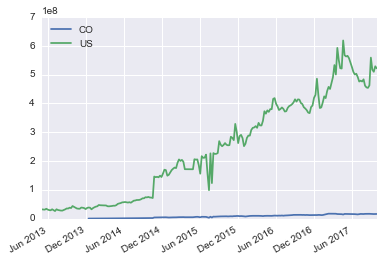

In [20]:
daily_aggregate.plot()

Obviously the curves above are on a different scale, and a more sensible number might be if we 'normalized' the data by population. It is easy to see that US is increasing over time. 

#### **TRY THIS!**

How correlated are Colombia and US? What do you think is driving the trends we see above?

You can customize your plots as well:

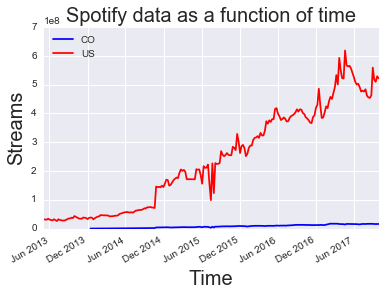

In [21]:
legend = {'CO':'b', 'US':'r'}
daily_aggregate.plot(style = legend)
plt.title("Spotify data as a function of time",fontsize=20)
plt.ylabel("Streams",fontsize=20)
plt.xlabel("Time",fontsize=20)

We can plot only the data from the US in 2017:

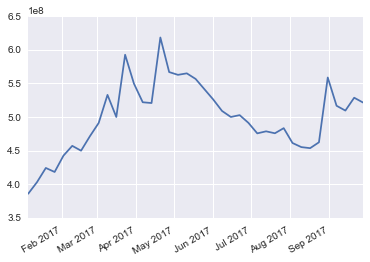

In [22]:
daily_aggregate[daily_aggregate.index.map(lambda x: x.year==2017)]['US'].plot()

#### **TRY THIS!**

Plot only the data in daily_aggregate for which the day is even. Hint: to get the day of the first entry in the df, you can do daily_aggregate.index[0].day. 

Pandas is good about ignoring days that are missing from the index when plotting, but you might not even be able to tell a difference between the plot when you filter by even day. Try printing the length of the dfs to confirm your filtering is doing the right thing.

Let's plot 2016 data by month:

In [23]:
_2016_data = daily_aggregate[daily_aggregate.index.map(lambda x: x.year==2016)]
_2016_monthly = _2016_data.groupby(lambda x:x.month).aggregate(np.sum)

In [ ]:
_2016_monthly.head()

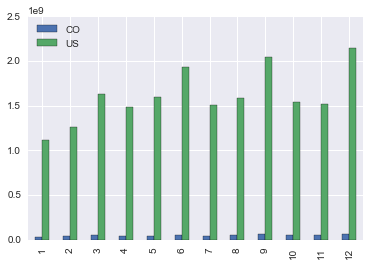

In [24]:
_2016_monthly.plot(kind='bar')

Do you think it is safe to make any conclusions about monthly trends from the plot above? What if we grouped the entire data set by month:

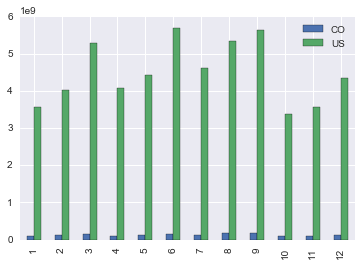

In [25]:
daily_aggregate.groupby(lambda x:x.month).aggregate(np.sum).plot(kind='bar')

The above bar plot seems entirely different. We shouldn't make conclusions about monthly patterns yet since we see a very obvious 'trend' in the data. In a later lesson, you will learn more about how to estimate models and extract 'residuals'. A related question is, how might we model the data as a function of time? Linear? Something else? Do you have a hypothesis for how this data might evolve? For instance, if I tell two people about Spotify, and they tell two people about Spotify, and they tell two people...

Now, let's test plotting the data by artist:

In [26]:
# We'll probably want to do a fillna(0) here, since a lot of the artists in the data set might not have been 
# streamed in the US or Colombia:
artist_daily = track_daily.groupby('Name').aggregate({'US':np.sum,'CO':np.sum}).dropna(how='all').fillna(0.)

artist_daily[artist_daily['CO']>artist_daily['US']]

,CO,US
Name,,
AC/DC,36300.0,0.0
Alejandro Fernandez,91470.0,0.0
Alejandro Sanz,521363.0,0.0
Alexis & Fido,7001186.0,0.0
Alkilados,3336128.0,0.0
Alkilados Feat Mike Bahia,992582.0,0.0
"Alkilados feat. Nicky Jam, J. Alvarez, El Roockie",2217669.0,0.0
Alle Farben,10932.0,0.0
Alvaro Soler,75096.0,0.0


Let's make a histogram of US artists (let's ignore all the ones who are at 0). We can drop data that's greater than 2 standard devs above the mean:

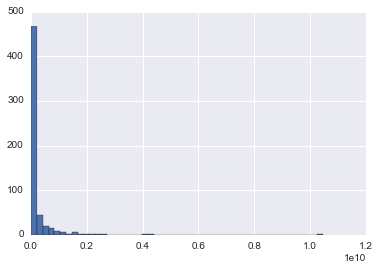

In [27]:
artist_daily[artist_daily['US']>0.]['US'].hist(bins=50)

(0, 20000000000.0)

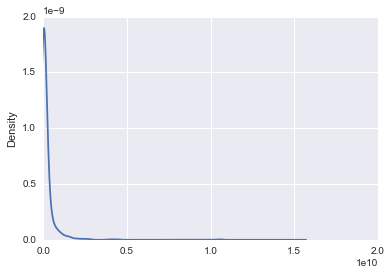

In [28]:
artist_daily[artist_daily['US']>0.]['US'].plot(kind='kde')
plt.xlim([0,None])

We can visualize the number of streams by artist in a particular time frame:

In [58]:
# Select a few artists:
gucci_and_drake = track_daily[track_daily['Name'].isin(['Gucci Mane','Drake'])]

# Select a time window:
gucci_and_drake = gucci_and_drake[(gucci_and_drake['Date']<20161001) & (gucci_and_drake['Date']>20150701)]

# Groupby day:
gucci_and_drake = gucci_and_drake.groupby('Date').aggregate(
    {'US':np.sum,'CO':np.sum, 'Name':lambda row: row.iloc[-1]})

# Convert the index:
gucci_and_drake.index = gucci_and_drake.index.map(lambda x:pd.to_datetime(str(int(x)), format='%Y%m%d'))

In [59]:
gucci_and_drake[gucci_and_drake['Name']=='Gucci Mane']

,CO,Name,US
2016-07-28,605606.0,Gucci Mane,61067835.0


We can make histograms as before using the tracks dataset:

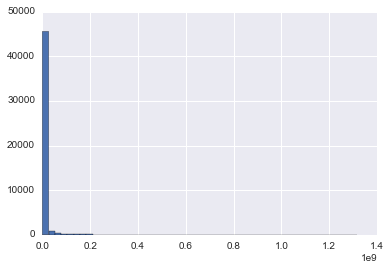

In [65]:
pd.to_numeric(tracks['Streams'].str.replace(",",""),errors='coerce').hist(bins=50)

We can make a histogram by artist as well:

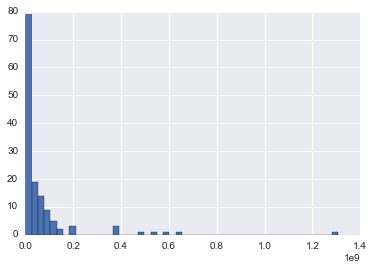

In [80]:
pd.to_numeric(
    tracks[tracks['Name']=='Drake']['Streams'].str.replace(",",""),
    errors='coerce').hist(bins=50)

Note that blindly using the KDE, which tries to estimate the probability distribution from which streams comes from, is problematic. Do you notice anything funny about the plot below?

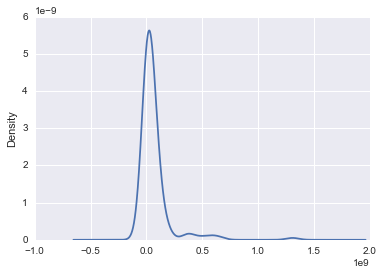

In [81]:
pd.to_numeric(
    tracks[tracks['Name']=='Drake']['Streams'].str.replace(",",""),
    errors='coerce').plot(kind='kde')

#### **TRY THIS!**

We've added a column called 'Name' to track_daily, which is the artist name. However, the tracks df has a column called Track_name. The tracks df also has a column called 'Peak Date'. 

1). Use a merge to add new columns, Track_name and Peak Date, to the track_daily df. (Be sure to use the `unique tracks' df below which filters out repeat rows based on the 'with' column). 

2). Pick a few songs to investigate. Plot the time series of streams for a few tracks (look at a few different countries). Look at 'Peak Date' for this song and whether or not it makes sense from your plot. 

The unique_tracks df you'll want to merge on will probably look like the following:

In [83]:
unique_tracks_2 = tracks[np.invert(tracks['TrackUrl'].duplicated())][['Track_name', 'TrackUrl', 'Peak Date']]

## 4. Random Numbers and Sampling

In [ ]:
'''
We can generate random numbers using numpy, a library for numerical computing in python
'''

## 5. Simulation for Data Analysis